<a href="https://colab.research.google.com/github/Matthew1320/Road-Sign-Detection/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary
import time
from tqdm.notebook import tqdm, trange
import torch.optim as optim
import random
import pickle
import tensorflow as tf
import time

In [ ]:
# Paths to images
annotations_path = '/content/drive/MyDrive/College/Junior/4701/data/annotations'
images_path = '/content/drive/MyDrive/College/Junior/4701/data/images/'
preprocessed = '/content/drive/MyDrive/College/Junior/4701/preprocessed/'
false_path = '/content/drive/MyDrive/College/Junior/4701/preprocessed/falses/'
train_path = preprocessed + 'train/'
test_path = preprocessed +'test/'
aug_path = preprocessed + 'augmented/'
train_full_path = preprocessed + 'train_full/'
test_full_path = preprocessed +'test_full/'
pickle = preprocessed + 'pickle/'

In [ ]:
# getAnnotations() goes into the folder containing all of the picture's annnotations
# and returns a list of all of the annotation files
def getAnnotations(annotations_path):
    ann = []
    for filename in os.listdir(annotations_path):
        f = os.path.join(annotations_path, filename)
        # checking if it is a file
        if os.path.isfile(f):
            ann.append(f)
    return ann

In [ ]:
# createDf() extracts the important features from the .xml annotation files
# for each of the pictures and puts them in a pandas dataframe that is returned
def createDf(annotations_path):
    annotations = getAnnotations(annotations_path)
    #https://docs.python.org/2/library/xml.etree.elementtree.html#module-xml.etree.ElementTree
    lst = []
    for a in annotations:
        example = {}
        tree = ET.parse(a)
        root = tree.getroot()
        # Need png name, width, height, depth, classification, lower left corner, upper right corner
        example['png file'] =  str(root.find('./filename').text)
        example['image_width'] = root.find('./size').find('./width').text
        example['image_height'] = root.find('./size').find('./height').text
        example['image_depth'] = root.find('./size').find('./depth').text
        example['classification'] = root.find('./object').find('./name').text
        example['x_min'] = root.find('./object').find('./bndbox').find('xmin').text
        example['x_max'] = root.find('./object').find('./bndbox').find('xmax').text
        example['y_min'] = root.find('./object').find('./bndbox').find('ymin').text
        example['y_max'] = root.find('./object').find('./bndbox').find('ymax').text
        example['diff_x'] = np.abs(int(example['x_min']) - int(example['x_max']))
        example['diff_y'] = np.abs(int(example['y_min']) - int(example['y_max']))
        lst.append(example)
    return pd.DataFrame.from_dict(lst)

In [ ]:
# Creating the data frame
data = createDf(annotations_path)
min_width = int(data['diff_x'].min())
min_height = int(data['diff_y'].min())
max_width = int(data['diff_x'].max())
max_height = int(data['diff_y'].max())
print(min_width, max_width, min_height, max_height)

8 383 7 383


In [ ]:
data

,png file,image_width,image_height,image_depth,classification,x_min,x_max,y_min,y_max,diff_x,diff_y
0,road1.png,400,283,3,trafficlight,154,258,63,281,104,218
1,road10.png,400,267,3,trafficlight,106,244,3,263,138,260
2,road0.png,267,400,3,trafficlight,98,208,62,232,110,170
3,road112.png,400,267,3,speedlimit,137,272,12,152,135,140
4,road103.png,400,301,3,speedlimit,89,297,25,272,208,247
...,...,...,...,...,...,...,...,...,...,...,...
872,road77.png,400,269,3,stop,171,382,14,234,211,220
873,road726.png,300,400,3,speedlimit,137,219,156,238,82,82
874,road566.png,300,400,3,speedlimit,77,127,238,289,50,51
875,road490.png,300,400,3,speedlimit,133,183,123,171,50,48


In [ ]:
# Visualize an image in the dataframe
def visuals(df):
  size = len(df)
  pic_id = random.randint(0, size - 1)
  path = df.get('png file')[pic_id]
  img = Image.open(images_path + path)
  plt.imshow(img)
  plt.show()

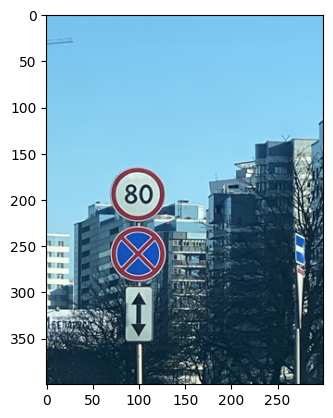

In [ ]:
visuals(data)

In [ ]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img

def augmentor(num,size, df):
  datagen = ImageDataGenerator(
        rotation_range = 15,
        shear_range = 0.2,
        zoom_range = .2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))
  
  augmented = pd.DataFrame(columns=['png file','image_width','image_height','image_depth','classification', 'x_min','x_max','y_min','y_max','diff_x',	'diff_y'])

  for i in range(num):

    pic_id = random.randint(0,size - 1)
    img = load_img(images_path + df.get('png file')[pic_id])
     
    # Converting the input sample image to an array
    x = img_to_array(img)
    # Reshaping the input image
    x = x.reshape((1, ) + x.shape) 
      
    # Generating and saving 5 augmented samples 
    # using the above defined parameters. 
    k = 0
    for batch in datagen.flow(x, batch_size = 1,
                              save_to_dir =preprocessed + 'augmented', 
                              save_prefix ='aug' + str(4*i + k), save_format ='png'):
      augmented.loc[4*i + k] = df.iloc[pic_id]
      augmented.loc[4*i + k,'png file'] = str(4*i + k)+'.png'

      k += 1
      if k > 3:
          break

  j = 0
  for name in os.listdir(preprocessed + 'augmented'):
    os.rename(preprocessed + 'augmented/' + name, preprocessed + 'augmented/' + str(j)+'.png')
    j+=1

  return augmented

In [ ]:
augmented = augmentor(125, len(data),data) #Adding 400 new augmented images
# augmented.to_pickle(pickle + "augmented.pkl")
augmented

,png file,image_width,image_height,image_depth,classification,x_min,x_max,y_min,y_max,diff_x,diff_y
0,0.png,300,400,3,speedlimit,73,107,168,203,34,35
1,1.png,300,400,3,speedlimit,73,107,168,203,34,35
2,2.png,300,400,3,speedlimit,73,107,168,203,34,35
3,3.png,300,400,3,speedlimit,73,107,168,203,34,35
4,4.png,300,400,3,speedlimit,99,150,211,261,51,50
...,...,...,...,...,...,...,...,...,...,...,...
495,495.png,400,267,3,stop,126,268,36,212,142,176
496,496.png,400,267,3,crosswalk,156,177,8,31,21,23
497,497.png,400,267,3,crosswalk,156,177,8,31,21,23
498,498.png,400,267,3,crosswalk,156,177,8,31,21,23


In [ ]:
# remove ones that didn't work correctly
def remover(df):
  j = 0
  for i in range(len(df)):
    try:
      a = Image.open(aug_path + df.get('png file')[i])
    except:
      j+=1
      df = df.drop(i)
  return df

In [ ]:
augmented = remover(augmented)
augmented

,png file,image_width,image_height,image_depth,classification,x_min,x_max,y_min,y_max,diff_x,diff_y
0,0.png,300,400,3,speedlimit,73,107,168,203,34,35
1,1.png,300,400,3,speedlimit,73,107,168,203,34,35
2,2.png,300,400,3,speedlimit,73,107,168,203,34,35
3,3.png,300,400,3,speedlimit,73,107,168,203,34,35
4,4.png,300,400,3,speedlimit,99,150,211,261,51,50
...,...,...,...,...,...,...,...,...,...,...,...
495,495.png,400,267,3,stop,126,268,36,212,142,176
496,496.png,400,267,3,crosswalk,156,177,8,31,21,23
497,497.png,400,267,3,crosswalk,156,177,8,31,21,23
498,498.png,400,267,3,crosswalk,156,177,8,31,21,23


In [ ]:
# helper() sets the boundary of the image so that the resulting image is as 
# large as possible while maintaining a rectangular shape and not including the
# sign that was originally in it
def helper(axis, maxMin, falses,i):
  if axis == 'image_width':
    if maxMin == 0:
      falses.loc[i,'x_max'] = int(falses.get('x_min')[i])
      falses.loc[i,'x_min'] = 0
      falses.loc[i,'y_min'] = 0
      falses.loc[i,'y_max'] = int(falses.get('image_height')[i])
    else:
      falses.loc[i,'x_min'] = int(falses.get('x_max')[i])
      falses.loc[i,'x_max'] = int(falses.get('image_width')[i])
      falses.loc[i,'y_min'] = 0
      falses.loc[i,'y_max'] = int(falses.get('image_height')[i])
  else:
    if maxMin == 0:
      falses.loc[i,'x_max'] = int(falses.get('image_width')[i])
      falses.loc[i,'x_min'] = 0
      falses.loc[i,'y_max'] = int(falses.get('y_min')[i])
      falses.loc[i,'y_min'] = 0
    else:
      falses.loc[i,'x_max'] = int(falses.get('image_width')[i])
      falses.loc[i,'x_min'] = 0
      falses.loc[i,'y_min'] = int(falses.get('y_max')[i])
      falses.loc[i,'y_max'] = int(falses.get('image_height')[i])


# addFalseImages(df,num) updates the dataframe df to include num images that do not 
# contain any road signs in them. It also saves the newly created false images
# to the false images folder
def addFalseImages(df,num):
  falses = df[:num].copy()
  for i in range(num):
    falses.loc[i,'classification'] = 'None' #Setting class to None
    falses.loc[i,'png file'] = 'false' + str(i) + '.png'
    x_right = int(falses.get('image_width')[i]) - int(falses.get('x_max')[i])
    x_left = int(falses.get('x_min')[i])
    y_top = int(falses.get('image_height')[i]) - int(falses.get('y_max')[i])
    y_bottom = int(falses.get('y_min')[i])
    big = max(x_right,x_left,y_bottom,y_top)
    if big == x_right:
      helper('image_width', 0, falses,i) #min = 0
    elif big == x_left:
      helper('image_width', 1, falses,i) #max = 1
    elif big == y_bottom:
      helper('image_height', 0, falses,i) #min = 0
    else:
      helper('image_height', 1, falses,i) #max = 1

  # Adds the new images to the desired location
  # for i in range(falses.shape[0]):
  #   img = np.array(Image.open(images_path + df.get('png file')[i]))
  #   img = img.astype(float)/255
  #   img = img[int(falses.get('y_min')[i]):int(falses.get('y_max')[i])+1,int(falses.get('x_min')[i]):int(falses.get('x_max')[i])+1]
  #   plt.imsave(false_path + falses.get('png file')[i], img)

  return falses

In [ ]:
# Adding the false images and concatenating the false data frame to the 
# Non-false data frame
falses = addFalseImages(data, 100)

In [ ]:
falses = falses.drop(labels = [22,27, 28,29,31,40,51,55,61,64,79,87,90,92], axis = 0)
full_data = pd.concat([data,falses,augmented], axis = 0, ignore_index=True)
full_data

,png file,image_width,image_height,image_depth,classification,x_min,x_max,y_min,y_max,diff_x,diff_y
0,road1.png,400,283,3,trafficlight,154,258,63,281,104,218
1,road10.png,400,267,3,trafficlight,106,244,3,263,138,260
2,road0.png,267,400,3,trafficlight,98,208,62,232,110,170
3,road112.png,400,267,3,speedlimit,137,272,12,152,135,140
4,road103.png,400,301,3,speedlimit,89,297,25,272,208,247
...,...,...,...,...,...,...,...,...,...,...,...
1412,495.png,400,267,3,stop,126,268,36,212,142,176
1413,496.png,400,267,3,crosswalk,156,177,8,31,21,23
1414,497.png,400,267,3,crosswalk,156,177,8,31,21,23
1415,498.png,400,267,3,crosswalk,156,177,8,31,21,23


In [ ]:
# reshape all images to img_width and img_height
# resize(height, width) resizes all of the images in the dataframe to be of
# dimension (height, width). This way all images are of the same size
def resize(h,w,df,path):
  for i in range(df.shape[0]):
    img = plt.imread(path + df.get('png file')[i])
    reshaped = cv2.resize(img, (w,h))
    plt.imsave(path + df.get('png file')[i], reshaped)

img_width = 224 #Default height and width for VGG16 is 224x224
img_height = 224

In [ ]:
from keras.applications import ResNet50V2
from keras.applications import VGG16

# Extract convolutional base to be used in transfer learning
conv = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Check architecture
conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
conv.save(pickle + 'ResNet50.h5')

In [ ]:
# splitHelp splits the dataframe df into a train and test dataframe, with the 
# train dataframe having about 90% of the data and the test having the remaining
# 10%
def splitHelp(df):
  shuffled = df.sample(frac = 1)
  size = df.shape[0]
  train = shuffled[:int(.9 * size)]
  test = shuffled[int(.9*size):]
  return train, test

# Split the dataframe df into a training dataframe and a testing dataframe,
# each with the data shuffled. The training dataframe will have roughly 90% of
# each class withing df and the testing dataframe will have the remaining 10%
def splitFrame(df):
  tl = df[df.get('classification') == 'trafficlight']
  sl = df[df.get('classification') == 'speedlimit']
  stop = df[df.get('classification') == 'stop']
  cw = df[df.get('classification') == 'crosswalk']
  false = df[df.get('classification') == 'None']

  tl_train, tl_test = splitHelp(tl)
  sl_train, sl_test = splitHelp(sl)
  stop_train, stop_test = splitHelp(stop)
  cw_train, cw_test = splitHelp(cw)
  false_train, false_test = splitHelp(false)

  train = pd.concat([tl_train, sl_train, stop_train, cw_train, false_train])
  test = pd.concat([tl_test, sl_test, stop_test, cw_test, false_test])

  return train.sample(frac = 1), test.sample(frac = 1)

In [ ]:
train, test = splitFrame(data)
f_train, f_test = splitFrame(falses)
aug_train, aug_test = splitFrame(augmented)
full_train = pd.concat([train,f_train,aug_train], axis = 0, ignore_index=True)
full_test = pd.concat([test,f_test,aug_test], axis = 0, ignore_index=True)
# Saving the split to a pickle 
full_train.to_pickle(pickle + "train_full_aug.pkl")  # where to save it, usually as a .pkl
full_test.to_pickle(pickle + "test_full_aug.pkl")
full_test

,png file,image_width,image_height,image_depth,classification,x_min,x_max,y_min,y_max,diff_x,diff_y
0,road458.png,300,400,3,speedlimit,67,139,116,189,72,73
1,road401.png,300,400,3,speedlimit,163,221,190,247,58,57
2,road227.png,300,400,3,speedlimit,141,153,181,193,12,12
3,road220.png,300,400,3,speedlimit,125,139,154,169,14,15
4,road153.png,400,337,3,crosswalk,111,346,0,299,235,299
...,...,...,...,...,...,...,...,...,...,...,...
141,205.png,300,400,3,speedlimit,115,130,131,148,15,17
142,322.png,300,400,3,speedlimit,134,195,154,214,61,60
143,319.png,300,400,3,speedlimit,98,134,170,207,36,37
144,273.png,300,400,3,speedlimit,136,155,200,218,19,18


In [ ]:
# Loading the pickle file
full_train = pd.read_pickle(pickle + "train_full_aug.pkl")
full_test = pd.read_pickle(pickle + "test_full_aug.pkl")

In [ ]:
# splitImage takes in a dataframe df and copies the image from the
# original location found by in_path and puts this copy at the new
# location defined by out_path
def splitImage(df,in_path,out_path):
  for i in df.get('png file'):
    img = plt.imread(in_path + i)
    plt.imsave(out_path + i, img)

In [ ]:
splitImage(train,images_path, train_full_path)
splitImage(f_train, false_path, train_full_path)
splitImage(aug_train, aug_path, train_full_path)

splitImage(test,images_path, test_full_path)
splitImage(f_test, false_path, test_full_path)
splitImage(aug_test, aug_path, test_full_path)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of tensor image data with real-time data augmentation.
# Rescaling the images to have pixel values between [0,1] and including
# a validation split of 0.2
generator=ImageDataGenerator(rescale=1./255.,validation_split=0.1)
batch_size = 32

In [ ]:
# Generating the training set from the training dataframe
train_generator=generator.flow_from_dataframe(
dataframe=full_train,
directory=train_full_path,
x_col="png file",
y_col="classification",
subset="training",
batch_size=batch_size,
seed=13,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

# Generating the validation set from the training dataframe
valid_generator=generator.flow_from_dataframe(
dataframe=full_train,
directory=train_full_path,
x_col="png file",
y_col="classification",
subset="validation",
batch_size=batch_size,
seed=13,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

# Generate batches of tensor image data with real-time data augmentation.
# Rescaling the images to have pixel values between [0,1]. This generator
# will be used for the test set. We create a new one as we don't want a
# validation split 
test_datagen=ImageDataGenerator(rescale=1./255.)

# Generating the test set from the test dataframe
test_generator=test_datagen.flow_from_dataframe(
dataframe=full_test,
directory=test_full_path,
x_col="png file",
y_col="classification",
batch_size=1,
seed=13,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 1144 validated image filenames belonging to 5 classes.
Found 127 validated image filenames belonging to 5 classes.
Found 146 validated image filenames belonging to 5 classes.


In [ ]:
# getFeatures takes in a training or test set and runs it through the
# convolutional base defined above. The predictions from the convolution
# model as well as the corresponding labels will be output, to later be 
# used in a classifier
def getFeatures(generator, size):
  feats = np.zeros((size, 7,7,512))
  classes = np.zeros((size,5))
  i = 0
  for images, labels in generator:
    imgFeatures = conv.predict(images)
    batch_size = imgFeatures.shape[0]
    feats[i : i + batch_size] = imgFeatures
    classes[i : i + batch_size] = labels
    i += batch_size
    if i == size:
      break

  return feats, classes

In [ ]:
train_feats, train_labels = getFeatures(train_generator,1144)
val_feats, val_labels = getFeatures(valid_generator,127)

1/1 [==============================] - 4s 4s/step


In [ ]:
test_feats, test_labels = getFeatures(test_generator,len(test_generator))

1/1 [==============================] - 0s 22ms/step


In [ ]:
def classifier():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GlobalAveragePooling2D(input_shape=(7,7,512)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(5, activation='sigmoid'))

    return model

model = classifier()

In [ ]:
def linearModel():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(7,7,512)))
  model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=(7*7*512)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(5, activation='sigmoid'))

  return model

model = linearModel()

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 25088)             0         
                                                                 
 dense_42 (Dense)            (None, 256)               6422784   
                                                                 
 batch_normalization_21 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 6,425,093
Trainable params: 6,424,581
Non-trainable params: 512
_________________________________________

In [ ]:
# Creating custom loss function to more heavily punish images being classified 
# as None when there is really a road sign in it
import keras.backend as K
def customLoss(y_true, y_pred):
  weights = [500,1,1,1,1] #Making the loss 100x as much for false positive Nones
  y_pred = K.softmax(y_pred, axis = 0)
  loss = -1 * y_true * K.log(y_pred) * weights
  loss = K.sum(loss, axis = 1)
  return loss

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=customLoss,
              metrics=['acc'])

In [ ]:
# Train model

epochs = 100
batch_size = 32

history = model.fit(train_feats, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(val_feats, val_labels))

Epoch 1/100
36/36 [==============================] - 2s 14ms/step - loss: 111.0490 - acc: 0.2614 - val_loss: 3.4170 - val_acc: 0.1024
Epoch 2/100
36/36 [==============================] - 0s 9ms/step - loss: 104.2794 - acc: 0.4318 - val_loss: 3.3815 - val_acc: 0.6457
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 100.5704 - acc: 0.5559 - val_loss: 3.3474 - val_acc: 0.6299
Epoch 4/100
36/36 [==============================] - 0s 9ms/step - loss: 96.9208 - acc: 0.6914 - val_loss: 3.3391 - val_acc: 0.4094
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 94.2794 - acc: 0.7517 - val_loss: 3.3207 - val_acc: 0.6142
Epoch 6/100
36/36 [==============================] - 0s 9ms/step - loss: 92.1261 - acc: 0.8295 - val_loss: 3.3329 - val_acc: 0.4961
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 92.1664 - acc: 0.8365 - val_loss: 3.3079 - val_acc: 0.8504
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss:

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=None,
              metrics=['acc'])
# model.save(pickle + 'vgg_linear_aug.h5')

In [ ]:
training_loss = history.history.get('loss')
training_acc = history.history.get('acc')
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

In [ ]:
def plot(plot_lists, ylabel, filename, color='tab:blue'):
  label = 'training'
  for lst in plot_lists:
    plt.plot(range(1, 101), lst, label = label)
    label = 'validation'

  plt.xlabel('iterations')
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(pickle + 'plots/' + filename + '.png')

  plt.show()

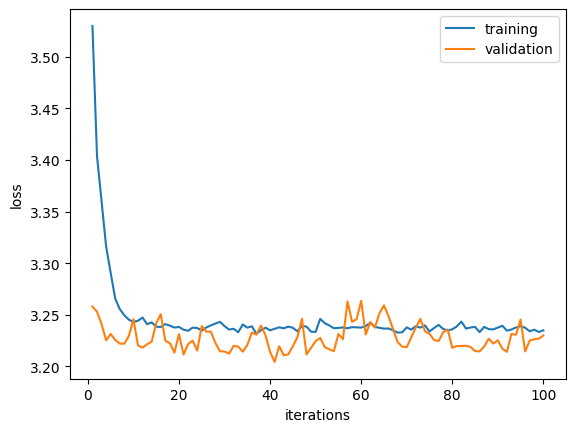

In [ ]:
losses = [training_loss, val_loss]
plot(losses, 'loss', 'vgg_linear_aug_losses')

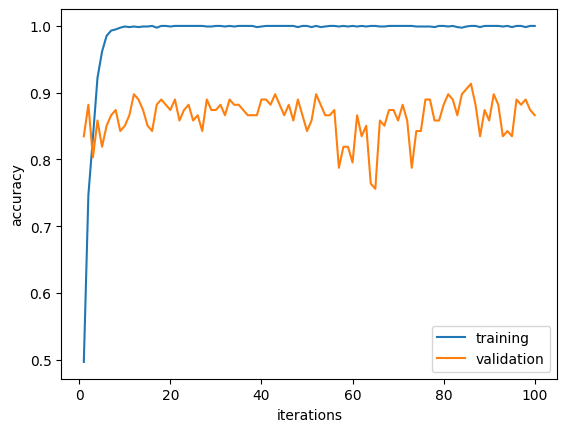

In [ ]:
acc = [training_acc, val_acc]
plot(acc, 'accuracy', 'vgg_linear_aug_acc')

In [ ]:
from PIL import Image
from tensorflow import keras
import numpy as np
import torch
import torchvision.transforms as transforms
from keras.utils import load_img, img_to_array


# conv_path = '/content/drive/MyDrive/College/Junior/4701/preprocessed/pickle/vgg.h5'
# model_path = '/content/drive/MyDrive/College/Junior/4701/preprocessed/pickle/ResNet_linear.h5'
# classifier = keras.models.load_model(model_path, compile = 'false')
# conv = keras.models.load_model(conv_path)

def t(df, size_df): 
  size = len(size_df)
  notFound = True

  false_pos = 0 #FP/FP+TN
  false_neg = 0 #FN/FN+TP
  tp = 0
  tn = 0
  j = 0

  false_path = '/content/drive/MyDrive/College/Junior/4701/data/falses/'
  for i in range(size):
      path = df.get('png file')[i]
      label = df.get('classification')[i]
      try:

        img = load_img(images_path + path, target_size=(img_width, img_height))
      except:
        try:
          img = load_img(false_path + path, target_size=(img_width, img_height))
        except:
          img = load_img(aug_path + path, target_size=(img_width, img_height))
      img_tensor = img_to_array(img)  # Image data encoded as integers in the 0–255 range
      img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
      start = time.time()
      features = conv.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
      prediction = model.predict(features)
      end = time.time()

      if i == 0:
        print(prediction)
        print(label)
      pred = np.argmax(prediction)

      if pred == 0:
        pred = 'None'
      elif pred == 1:
        pred = 'crosswalk'
      elif pred == 2:
        pred = 'speedlimit'
      elif pred == 3:
        pred = 'stopsign'
      else:
        pred = 'trafficlight'

      if label == 'None':
        tp += 1
        if pred != label:
          false_neg += 1
      else:
        tn += 1
        if pred == 'None':
          false_pos += 1

  print('false pos: ' + str(false_pos))
  print('false neg: ' + str(false_neg))
  print('tn: ' + str(tn))
  print('tp: ' + str(tp))


In [ ]:
t(full_test,full_test)

1/1 [==============================] - 0s 64ms/step
[[3.0868479e-05 9.3328215e-02 9.6755546e-01 2.9515071e-05 3.5808382e-03]]
speedlimit
1/1 [==============================] - 0s 30ms/step
false pos: 7
false neg: 0
tn: 137
tp: 9
146


In [ ]:
# model_path = '/content/drive/MyDrive/College/Junior/4701/preprocessed/pickle/ResNet_linear.h5'
# model2 = keras.models.load_model(model_path, compile = 'false')
def evaluateTest(test):
  start = time.time()
  feats, labels = getFeatures(test,len(test))
  score = model.evaluate(feats, labels, verbose = 1)
  end = time.time()
  total = end - start
  print(score)
  print("Total time: " + str(total))
  print("Average time: " + str(total/len(test)))

In [ ]:
evaluateTest(test_generator)

5/5 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - acc: 0.8904
[0.0, 0.8904109597206116]
Total time: 12.291864156723022
Average time: 0.08419085038851386
